<b><font color="SteelBlue" size="+3">Segmentez des clients d'un site e-commerce</font></b>

# Introduction

Ce notebook la partie contrat de maintenance du projet pour OLIST.

## Imports

In [1]:
%load_ext pycodestyle_magic

In [2]:
%pycodestyle_on

In [3]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
from sklearn.cluster import KMeans

# Metrics
from sklearn.metrics import adjusted_rand_score
from scipy.stats import ks_2samp

## Data

In [4]:
os.listdir()

['.ipynb_checkpoints',
 'Brazil_Regions.png',
 'carte-bresil.jpg',
 'Carte_bresil.png',
 'data',
 'Deveau_Estelle_1_script_032024.sql',
 'Deveau_Estelle_2_notebook_exploration_032024.ipynb',
 'Deveau_Estelle_3_notebook_essais_032024.ipynb',
 'Deveau_Estelle_4_notebook_simulation_032024.ipynb',
 'svg']

In [5]:
os.listdir("data/sources/")

['Customer.csv',
 'CustomerCategoryCounts.csv',
 'CustomerPaymentPreferences.csv',
 'periodes',
 'Script-avec-periode.sql',
 'Script_projet.sql',
 'svg_scripts']

In [6]:
os.listdir("data/sources/periodes")

['Customer', 'Payment', 'svg']

In [7]:
os.listdir("data/sources/periodes/Customer")

['Customer_170101_180101.csv',
 'Customer_170101_180115.csv',
 'Customer_170101_180201.csv',
 'Customer_170101_180215.csv',
 'Customer_170101_180301.csv',
 'Customer_170101_180315.csv',
 'Customer_170101_180401.csv',
 'Customer_170101_180415.csv',
 'Customer_170101_180501.csv',
 'Customer_170101_180515.csv',
 'Customer_170101_180601.csv',
 'Customer_170101_180615.csv',
 'Customer_170101_180701.csv',
 'Customer_170101_180715.csv',
 'Customer_170101_180801.csv']

In [8]:
os.listdir("data/sources/periodes/Payment")

['CustomerPaymentPreferences_170101_180101.csv',
 'CustomerPaymentPreferences_170101_180115.csv',
 'CustomerPaymentPreferences_170101_180201.csv',
 'CustomerPaymentPreferences_170101_180215.csv',
 'CustomerPaymentPreferences_170101_180301.csv',
 'CustomerPaymentPreferences_170101_180315.csv',
 'CustomerPaymentPreferences_170101_180401.csv',
 'CustomerPaymentPreferences_170101_180415.csv',
 'CustomerPaymentPreferences_170101_180501.csv',
 'CustomerPaymentPreferences_170101_180515.csv',
 'CustomerPaymentPreferences_170101_180601.csv',
 'CustomerPaymentPreferences_170101_180615.csv',
 'CustomerPaymentPreferences_170101_180701.csv',
 'CustomerPaymentPreferences_170101_180715.csv',
 'CustomerPaymentPreferences_170101_180801.csv']

# Liste des fichiers

In [9]:
pathCustomer = "./data/sources/periodes/Customer"
pathPayment = "./data/sources/periodes/Payment"

In [10]:
# Obtenir la liste des fichiers CSV dans chaque répertoire
data_customer = sorted([os.path.join(pathCustomer, f)
                        for f in os.listdir(pathCustomer)
                        if f.endswith('.csv')])
data_payment = sorted([os.path.join(pathPayment, f)
                       for f in os.listdir(pathPayment)
                       if f.endswith('.csv')])

# Prétraitement des données

In [11]:
def merge(df_customer, df_payment):
    # Calculer la somme totale des paiements pour chaque client
    total_payment_by_customer = df_payment.groupby(
        'customer_unique_id')['TotalPaymentValue'].sum()

    # Calculer la somme totale des échéances de paiement pour chaque client
    total_installments_by_customer = df_payment.groupby(
        'customer_unique_id')['TotalInstallments'].sum()

    # Somme totale des paiements et des échéances de paiement
    total_by_customer = pd.concat([total_payment_by_customer,
                                   total_installments_by_customer],
                                  axis=1).reset_index()

    # Pivot pour obtenir le pourcentage par type de paiement pour chaque client
    df_payment_pivot = df_payment.pivot_table(index='customer_unique_id',
                                              columns='payment_type',
                                              values='TotalPaymentValue',
                                              aggfunc='sum',
                                              fill_value=0)

    # Calculer les pourcentages de paiement pour chaque type
    for col in df_payment_pivot.columns:
        col_pct_name = f'{col}_pct'
        df_payment_pivot[col_pct_name] = (df_payment_pivot[col]
                                          / total_by_customer.set_index(
                                              'customer_unique_id'
                                          )['TotalPaymentValue']
                                          * 100)

    # Ajouter les données totales au DataFrame pivoté
    df_payment_pivot = df_payment_pivot.merge(
        total_by_customer, on='customer_unique_id')

    # Fusionner df_customer avec les colonnes sélectionnées de df_payment_pivot
    df_merged = pd.merge(df_customer,
                         df_payment_pivot[['customer_unique_id', 'boleto_pct',
                                           'credit_card_pct', 'debit_card_pct',
                                           'voucher_pct', 'TotalPaymentValue',
                                           'TotalInstallments']],
                         on='customer_unique_id',
                         how='left')

    return df_merged

In [12]:
def nettoyage(data):
    # Formats
    data['FirstOrderDate'] = pd.to_datetime(data['FirstOrderDate'])
    data['LastOrderDate'] = pd.to_datetime(data['LastOrderDate'])

    # doublons
    data = data.drop_duplicates(subset=["customer_unique_id"])
    data = data.drop_duplicates(subset=['FirstOrderDate',
                                        'TotalSpent', 'customer_city'])

    return data

In [13]:
def verification(data):
    tolerance = 0.1
    data = data.copy()

    # Vérifier que la somme des pourcentages des sommes dépensées
    # dans chaque catégorie est proche de 100%
    data = data[(abs(data['boleto_pct']
                     + data['credit_card_pct']
                     + data['debit_card_pct']
                     + data['voucher_pct']
                     - 100) <= tolerance)]

    # Vérifier la cohérence entre la valeur totale des paiements
    # et la somme de TotalSpent + TotalFreight
    data['payment_difference'] = abs(data['TotalPaymentValue']
                                     - (data['TotalSpent']
                                        + data['TotalFreight']))
    data = data[data['payment_difference'] <= (data['TotalPaymentValue']
                                               * tolerance)]

    # Supprimer les lignes où 'AverageReviewScore'
    # n'est pas compris entre 0 et 5
    data = data.query(
        "AverageReviewScore.isna() or "
        "(AverageReviewScore >= 0 and AverageReviewScore <= 5)")

    # Supprimer les lignes où 'NumberOfComments' ou 'NumberOfCommentTitles'
    # est supérieur à 'NumberOfReviews'
    data = data.query("NumberOfComments <= NumberOfReviews and "
                      "NumberOfCommentTitles <= NumberOfReviews")

    # Remplacer les valeurs de 'DifferentCategories' égales à 0 par 1
    data.loc[data['DifferentCategories'] == 0, 'DifferentCategories'] = 1

    # Suppression des colonnes qui servaient à la verification des données
    data = data.drop(columns=['TotalPaymentValue'])

    return data

In [14]:
def completion(data):
    # Supprimer les lignes où la colonne 'AvgWeight' est NaN
    data = data.dropna(subset=['AvgWeight'])

    return data

In [15]:
def featuring(df, featureslist):
    df = df.copy()

    # Recence
    reference_date = df['LastOrderDate'].max()
    df['Recency'] = (reference_date - df['LastOrderDate']).dt.days

    # Frequence
    df['Frequency'] = df['TotalOrders']

    # Montant (= panier moyen)
    df['TotalAmount'] = df['TotalSpent'] + df['TotalFreight']
    df['AvgBasket'] = df['TotalAmount']/df['TotalOrders']

    # Calcul de l'indice d'engagement en fonction des commentaires
    df['EngagementIndex'] = (0.5 * df['NumberOfReviews']
                             + 0.25 * df['NumberOfCommentTitles']
                             + 0.25 * df['NumberOfComments']) / (df['nb_item'])

    df = df[['customer_unique_id'] + featureslist]

    return df

In [16]:
standard_scaler = StandardScaler()


def scale(data):
    # Définir 'customer_unique_id' comme l'index du DataFrame
    data = data.set_index('customer_unique_id')

    scaled_data = pd.DataFrame(standard_scaler.fit_transform(data),
                               index=data.index,
                               columns=data.columns)

    return scaled_data

In [17]:
def traitement(file_cutomer, file_payment, featureslist):
    df_merged = merge(file_cutomer, file_payment)
    df_cleaned = nettoyage(df_merged)
    df_verified = verification(df_cleaned)
    df_completed = completion(df_verified)
    df_featured = featuring(df_completed, featureslist)
    df_scaled = scale(df_featured)

    return df_scaled

In [18]:
def traitement_noscale(file_cutomer, file_payment, featureslist):
    df_merged = merge(file_cutomer, file_payment)
    df_cleaned = nettoyage(df_merged)
    df_verified = verification(df_cleaned)
    df_completed = completion(df_verified)
    df_featured = featuring(df_completed, featureslist)

    return df_featured

# Détermination de la période de réentrainement conseillée

## ARI et KS

In [19]:
# Calcul ARI
def ari_calc(customer_files, payment_files, nbclusters, featurelist):

    ari_scores = []

    # Initialiser KMeans une seule fois avec le nombre de clusters déterminé
    kmeans = KMeans(n_clusters=nbclusters, random_state=42, n_init=10)
    customer_labels_first_period = {}

    for i, (file_customer, file_payment) in enumerate(zip(customer_files,
                                                          payment_files)):
        # Charger les fichiers CSV
        df_customer = pd.read_csv(file_customer)
        df_payment = pd.read_csv(file_payment)

        # Prétraitement
        data = traitement(df_customer,
                          df_payment, features)

        if i == 0:
            # Entraîner KMeans sur la première période
            kmeans.fit(data[featurelist])
            # identifiant des client p1
            customer_ids_first_period = set(data.index)
            # Stockage des labels de la première période
            customer_labels_first_period = {idx: lbl
                                            for idx, lbl
                                            in zip(data.index, kmeans.labels_)}
            ari_scores.append(1.0)
        else:
            # Filtrer pour ne garder que les clients présents
            # lors de la première période
            data_common = data.loc[data.index.isin(
                customer_ids_first_period)].copy()
            # prediction
            predicted_clusters = kmeans.predict(data_common[featurelist])
            # Filtrer labels_de_reference pour ne garder
            # que ceux correspondant aux clients communs
            labels_de_reference = [customer_labels_first_period[idx]
                                   for idx in data_common.index
                                   if idx in customer_labels_first_period]
            # Calcul de l'ARI
            ari = adjusted_rand_score(labels_de_reference, predicted_clusters)
            ari_scores.append(ari)

    return ari_scores

In [20]:
# Test de KS
def ks_analysis_between_periods(file_customer_previous,
                                file_payment_previous,
                                file_customer_current,
                                file_payment_current, features):
    # Charger les données pour les deux périodes
    df_customer_previous = pd.read_csv(file_customer_previous)
    df_payment_previous = pd.read_csv(file_payment_previous)
    data_previous = traitement(df_customer_previous,
                               df_payment_previous,
                               features)

    df_customer_current = pd.read_csv(file_customer_current)
    df_payment_current = pd.read_csv(file_payment_current)
    data_current = traitement(df_customer_current,
                              df_payment_current,
                              features)

    # Initialiser un dictionnaire pour stocker les résultats du test KS
    ks_results = {}

    # Exécuter le test KS pour chaque feature
    for feature in features:
        sample1 = data_previous[feature].dropna()
        sample2 = data_current[feature].dropna()
        ks_statistic, p_value = ks_2samp(sample1, sample2)
        ks_results[feature] = {'ks_statistic': ks_statistic,
                               'p_value': p_value}

    return ks_results

### 12 indicateurs

In [21]:
# liste des features
features = ['Recency', 'Frequency', 'AvgBasket', 'nb_item',
            'AverageReviewScore', 'EngagementIndex', 'DeliveryDelay',
            'AvgWeight', 'TotalInstallments', 'ActualDeliveryTime',
            'boleto_pct', 'voucher_pct']

#### ARI

In [22]:
ari_scores = ari_calc(data_customer, data_payment, 12, features)
ari_scores

[1.0,
 0.948096511991848,
 0.8895324023843055,
 0.8542476927979371,
 0.8093342333747267,
 0.763896261729035,
 0.7150497678496066,
 0.6886152837133425,
 0.665310866314249,
 0.6420997373847995,
 0.6249300387918112,
 0.6119066167885442,
 0.6006635592539947,
 0.5927623729482271,
 0.5786769588589482]

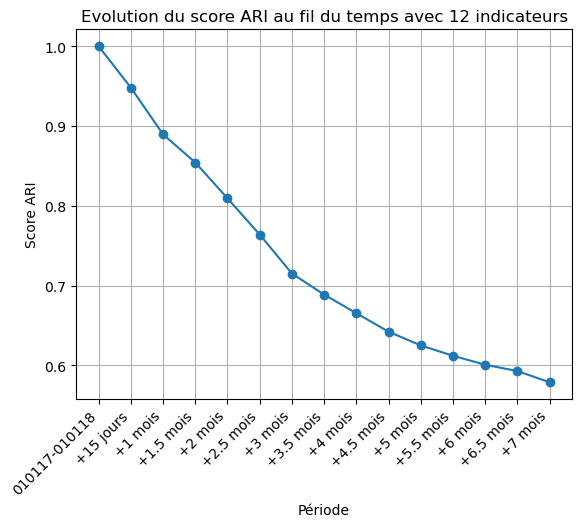

In [23]:
# Affichage de la courbe ARI
plt.plot(ari_scores, marker='o', linestyle='-')
plt.title('Evolution du score ARI au fil du temps avec 12 indicateurs')
plt.xlabel('Période')
plt.ylabel('Score ARI')
plt.xticks(range(len(ari_scores)), ['010117-010118', '+15 jours', '+1 mois',
                                    '+1.5 mois', '+2 mois', '+2.5 mois',
                                    '+3 mois', '+3.5 mois', '+4 mois',
                                    '+4.5 mois', '+5 mois', '+5.5 mois',
                                    '+6 mois', '+6.5 mois', '+7 mois'],
           rotation=45, ha='right')
plt.grid(True)
plt.show()

#### Kolmogorov-Smirnov

In [24]:
ks_results_all_periods = []

for i in range(len(data_customer) - 1):
    ks_results = ks_analysis_between_periods(data_customer[i],
                                             data_payment[i],
                                             data_customer[i+1],
                                             data_payment[i+1],
                                             features)
    ks_results_all_periods.append(ks_results)

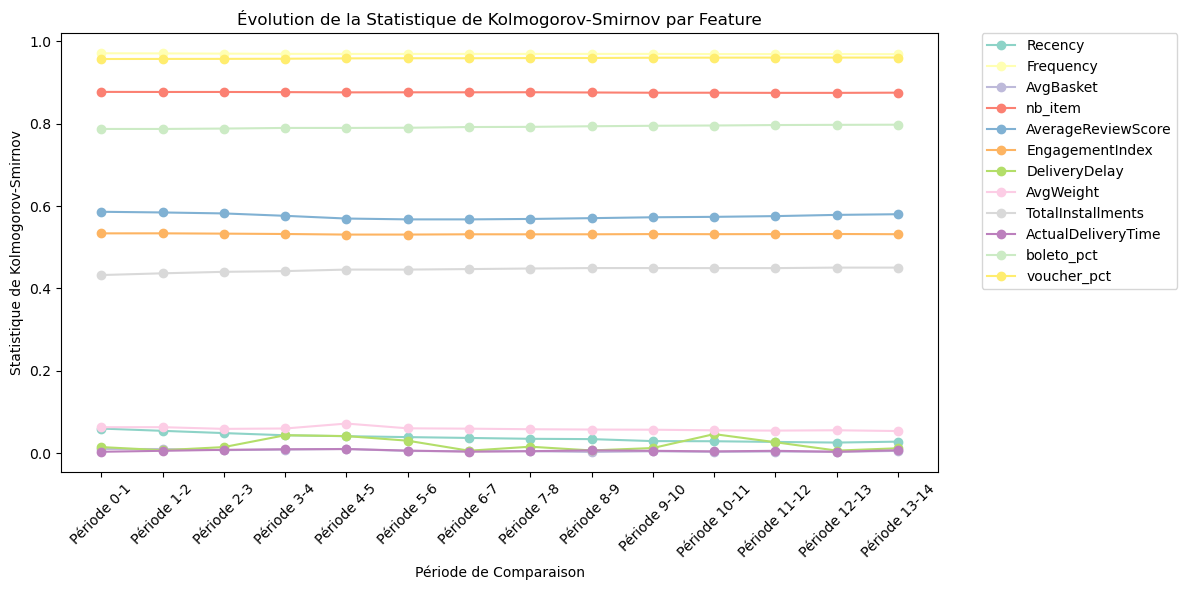

In [25]:
# Affichage de l'evolution KS
plt.figure(figsize=(12, 6))

# Nombre de périodes à comparer (nombre de tests KS réalisés)
n_periods = len(ks_results_all_periods)

palette = sns.color_palette('Set3', n_colors=len(features))

# Pour chaque feature, tracer les statistiques KS
for i, feature in enumerate(features):
    ks_statistics = [result[feature]['ks_statistic']
                     for result in ks_results_all_periods]
    plt.plot(range(n_periods), ks_statistics,
             marker='o', linestyle='-',
             label=feature, color=palette[i])

plt.xticks(range(n_periods), [f'Période {i}-{i+1}'
                              for i in range(n_periods)], rotation=45)
plt.xlabel('Période de Comparaison')
plt.ylabel('Statistique de Kolmogorov-Smirnov')
plt.title('Évolution de la Statistique de Kolmogorov-Smirnov par Feature')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

### 9 indicateurs

In [26]:
# liste des features
features9 = ['Recency', 'Frequency', 'AvgBasket', 'nb_item',
             'AverageReviewScore', 'EngagementIndex', 'DeliveryDelay',
             'boleto_pct', 'voucher_pct']

#### ARI

In [27]:
ari_scores = ari_calc(data_customer, data_payment, 12, features9)
ari_scores

[1.0,
 0.9420503032737811,
 0.8807022345261986,
 0.8388556648173933,
 0.7893320956184138,
 0.7401911263003161,
 0.6852847530004492,
 0.6562935000132163,
 0.6293980243375822,
 0.6052670566922422,
 0.5873529354111591,
 0.5738999459225258,
 0.559981326339682,
 0.5517827450212225,
 0.5414165950201779]

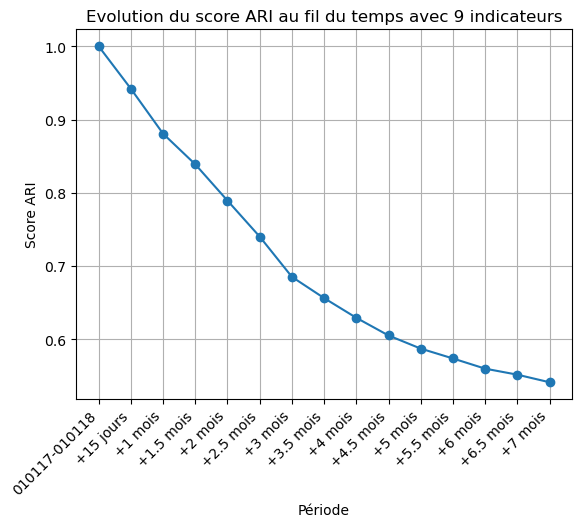

In [28]:
# Affichage de la courbe ARI
plt.plot(ari_scores, marker='o', linestyle='-')
plt.title('Evolution du score ARI au fil du temps avec 9 indicateurs')
plt.xlabel('Période')
plt.ylabel('Score ARI')
plt.xticks(range(len(ari_scores)), ['010117-010118', '+15 jours', '+1 mois',
                                    '+1.5 mois', '+2 mois', '+2.5 mois',
                                    '+3 mois', '+3.5 mois', '+4 mois',
                                    '+4.5 mois', '+5 mois', '+5.5 mois',
                                    '+6 mois', '+6.5 mois', '+7 mois'],
           rotation=45, ha='right')
plt.grid(True)
plt.show()

#### Kolmogorov-Smirnov

In [29]:
ks_results_all_periods = []

for i in range(len(data_customer) - 1):
    ks_results = ks_analysis_between_periods(data_customer[i],
                                             data_payment[i],
                                             data_customer[i+1],
                                             data_payment[i+1],
                                             features)
    ks_results_all_periods.append(ks_results)

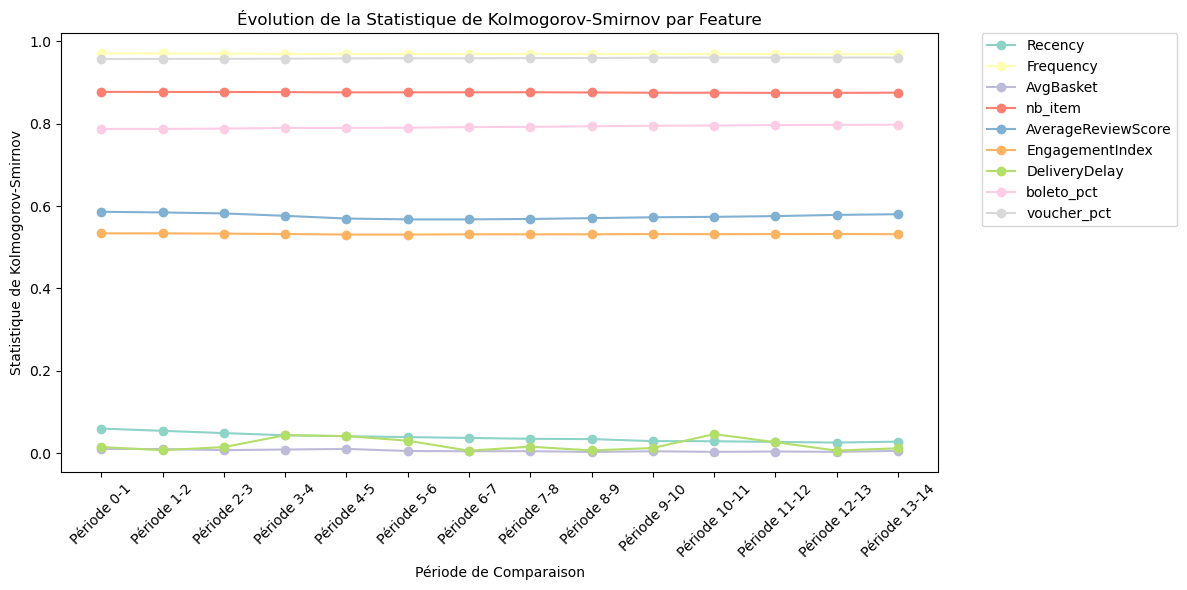

In [30]:
# Affichage de l'evolution KS
plt.figure(figsize=(12, 6))

# Nombre de périodes à comparer (nombre de tests KS réalisés)
n_periods = len(ks_results_all_periods)

palette = sns.color_palette('Set3', n_colors=len(features9))

# Pour chaque feature, tracer les statistiques KS
for i, feature in enumerate(features9):
    ks_statistics = [result[feature]['ks_statistic']
                     for result in ks_results_all_periods]
    plt.plot(range(n_periods), ks_statistics,
             marker='o', linestyle='-',
             label=feature, color=palette[i])

plt.xticks(range(n_periods), [f'Période {i}-{i+1}'
                              for i in range(n_periods)], rotation=45)
plt.xlabel('Période de Comparaison')
plt.ylabel('Statistique de Kolmogorov-Smirnov')
plt.title('Évolution de la Statistique de Kolmogorov-Smirnov par Feature')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

### 7 indicateurs

In [31]:
# liste des features
features7 = ['Recency', 'Frequency', 'AvgBasket', 'nb_item',
             'AverageReviewScore', 'EngagementIndex', 'DeliveryDelay']

#### ARI

In [32]:
ari_scores = ari_calc(data_customer, data_payment, 9, features7)
ari_scores

[1.0,
 0.9474181342803109,
 0.8793057236943966,
 0.8296714615903195,
 0.7715429141428063,
 0.7242211159226349,
 0.6719946471039656,
 0.6306548388410942,
 0.5742375187156933,
 0.5213473971502675,
 0.49026713289062956,
 0.4688191393909934,
 0.44436839203137257,
 0.42734008123077416,
 0.3966156384404805]

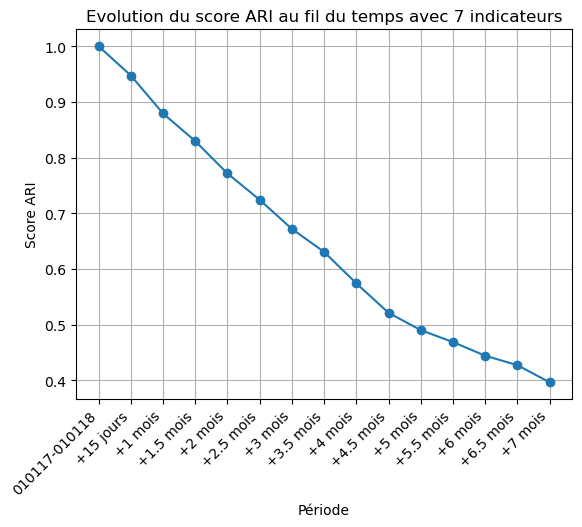

In [33]:
# Affichage de la courbe ARI
plt.plot(ari_scores, marker='o', linestyle='-')
plt.title('Evolution du score ARI au fil du temps avec 7 indicateurs')
plt.xlabel('Période')
plt.ylabel('Score ARI')
plt.xticks(range(len(ari_scores)), ['010117-010118', '+15 jours', '+1 mois',
                                    '+1.5 mois', '+2 mois', '+2.5 mois',
                                    '+3 mois', '+3.5 mois', '+4 mois',
                                    '+4.5 mois', '+5 mois', '+5.5 mois',
                                    '+6 mois', '+6.5 mois', '+7 mois'],
           rotation=45, ha='right')
plt.grid(True)
plt.show()

#### Kolmogorov-Smirnov

In [34]:
ks_results_all_periods = []

for i in range(len(data_customer) - 1):
    ks_results = ks_analysis_between_periods(data_customer[i],
                                             data_payment[i],
                                             data_customer[i+1],
                                             data_payment[i+1],
                                             features)
    ks_results_all_periods.append(ks_results)

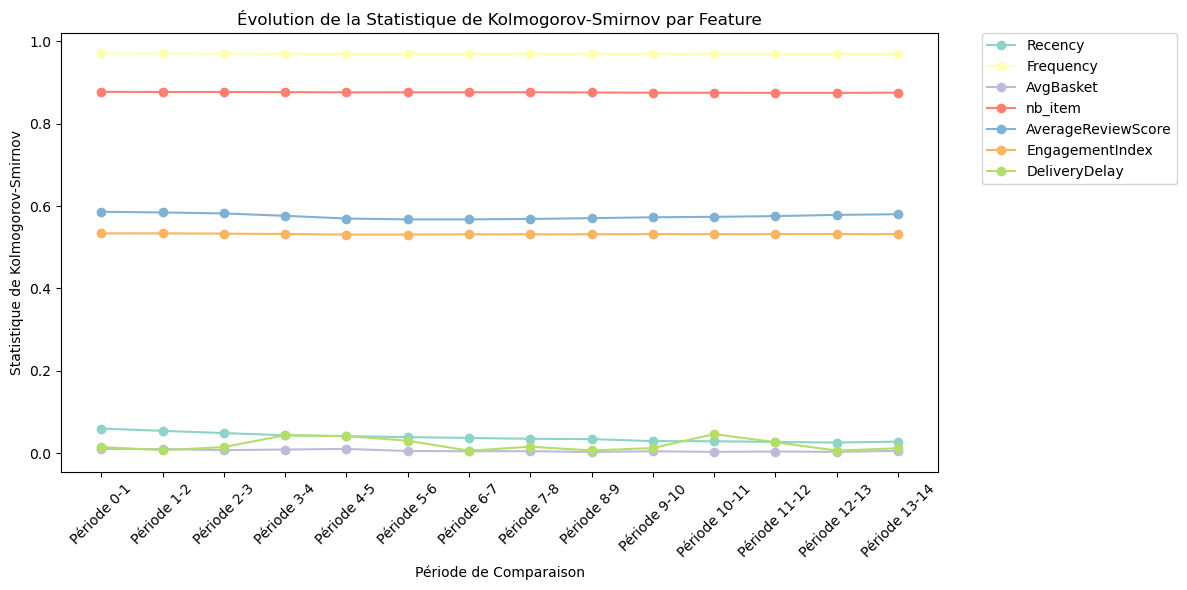

In [35]:
# Affichage de l'evolution KS
plt.figure(figsize=(12, 6))

# Nombre de périodes à comparer (nombre de tests KS réalisés)
n_periods = len(ks_results_all_periods)

palette = sns.color_palette('Set3', n_colors=len(features7))

# Pour chaque feature, tracer les statistiques KS
for i, feature in enumerate(features7):
    ks_statistics = [result[feature]['ks_statistic']
                     for result in ks_results_all_periods]
    plt.plot(range(n_periods), ks_statistics,
             marker='o', linestyle='-',
             label=feature, color=palette[i])

plt.xticks(range(n_periods), [f'Période {i}-{i+1}'
                              for i in range(n_periods)], rotation=45)
plt.xlabel('Période de Comparaison')
plt.ylabel('Statistique de Kolmogorov-Smirnov')
plt.title('Évolution de la Statistique de Kolmogorov-Smirnov par Feature')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

## Graphiques d'évolution

### Distributions

In [36]:
# Graph de distribution
def graphDistri(customer_files, payment_files, featurelist):
    allData = pd.DataFrame()
    for i, (file_customer, file_payment) in enumerate(zip(customer_files,
                                                          payment_files)):
        # Charger les fichiers CSV
        df_customer = pd.read_csv(file_customer)
        df_payment = pd.read_csv(file_payment)

        # Prétraitement
        data = traitement_noscale(df_customer,
                                  df_payment, features)

        # Ajout de la colonne periode
        data['Periode'] = i

        # Ajout des données au df général
        allData = pd.concat([allData, data])

    for feature in features:
        g = sns.FacetGrid(allData, col='Periode', col_wrap=15, height=3)
        g = g.map(sns.histplot, feature, kde=False)
    plt.show()

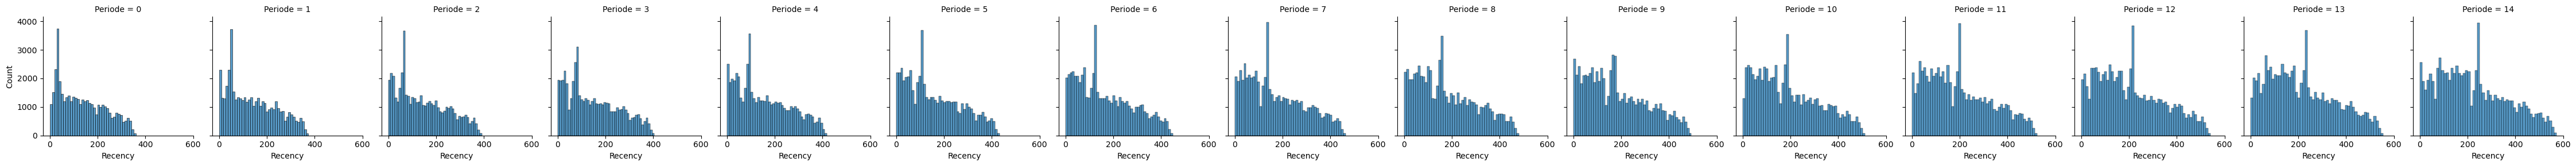

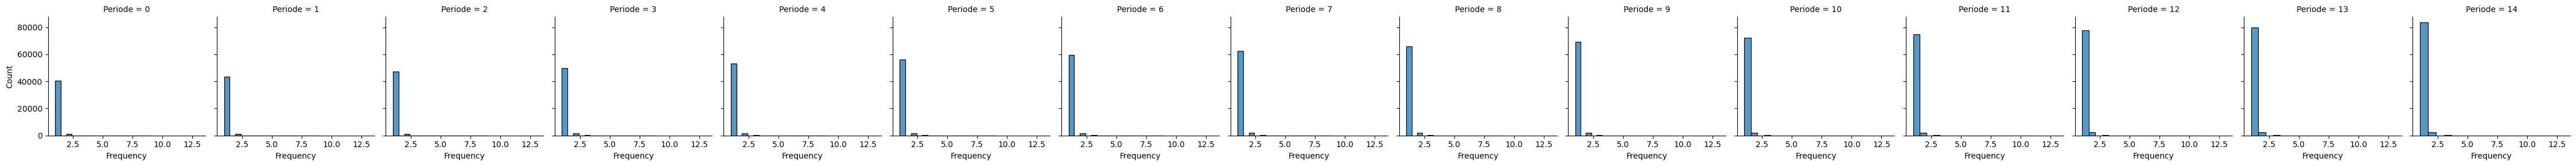

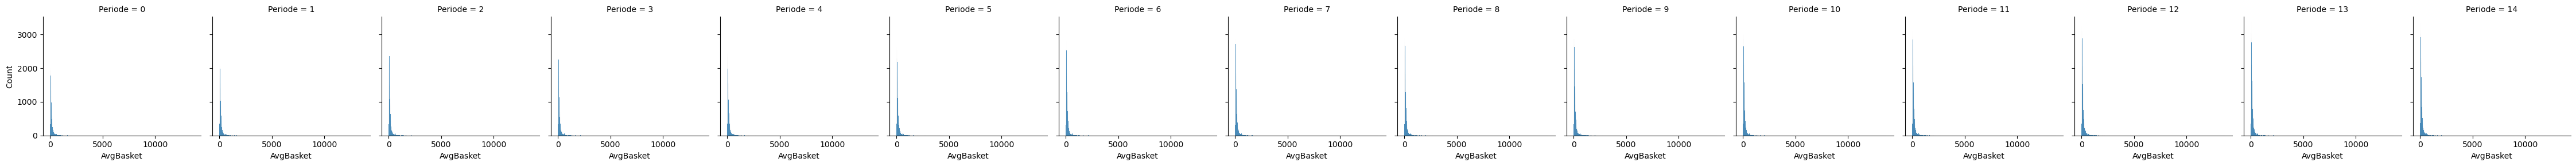

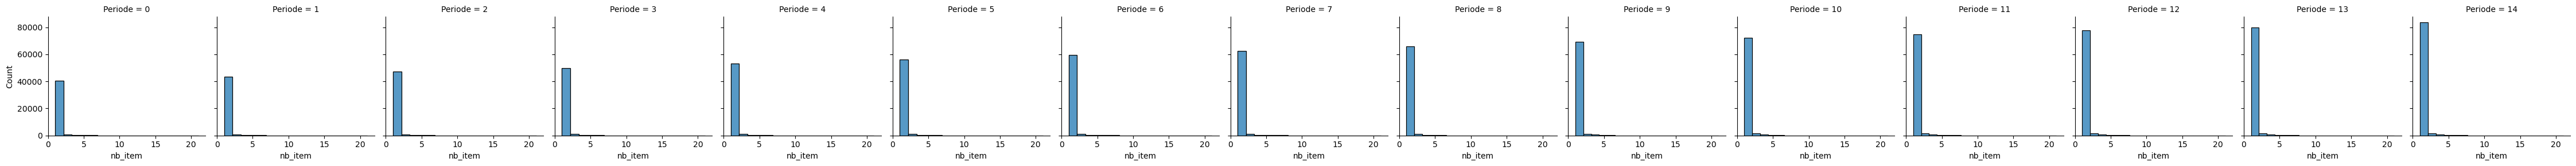

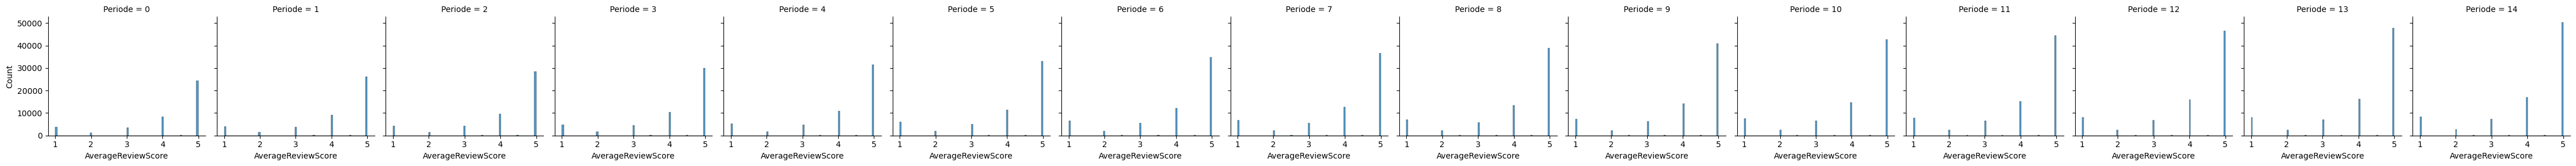

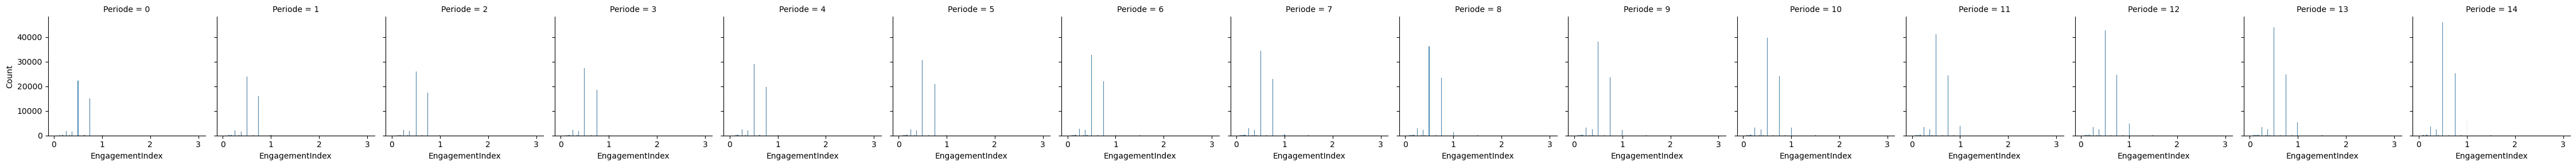

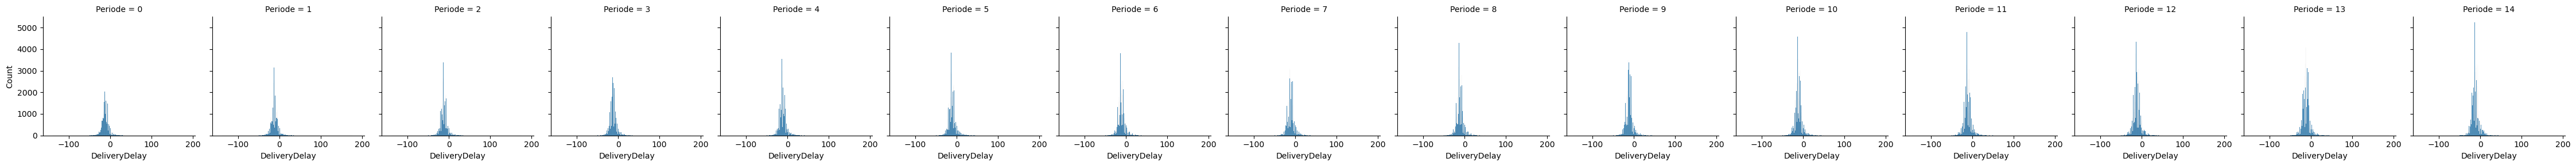

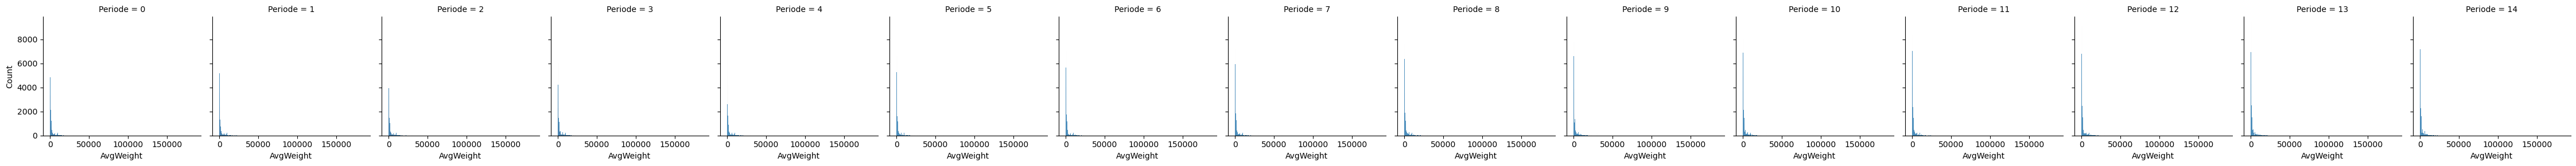

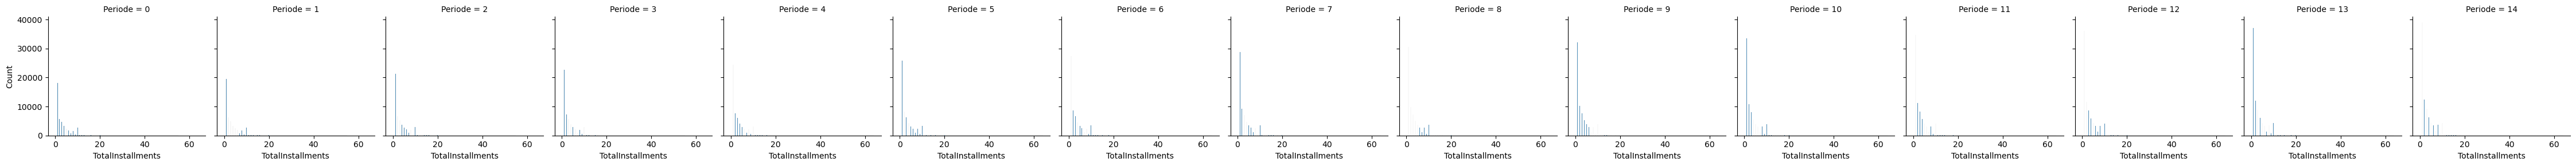

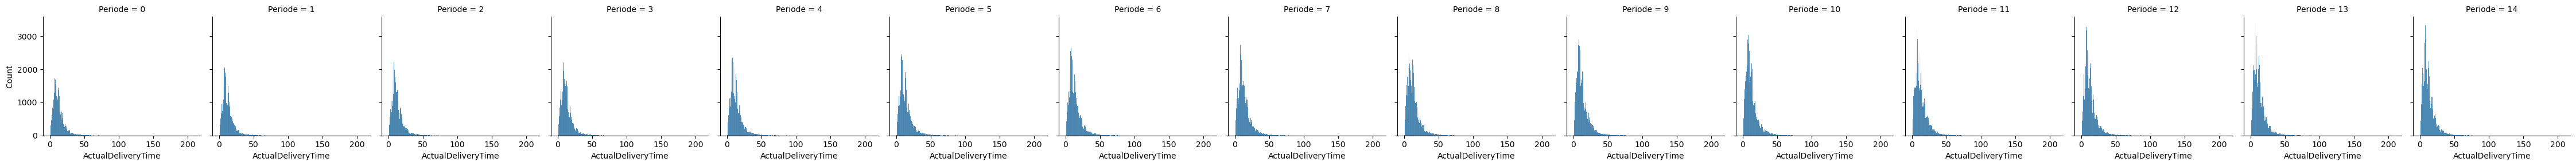

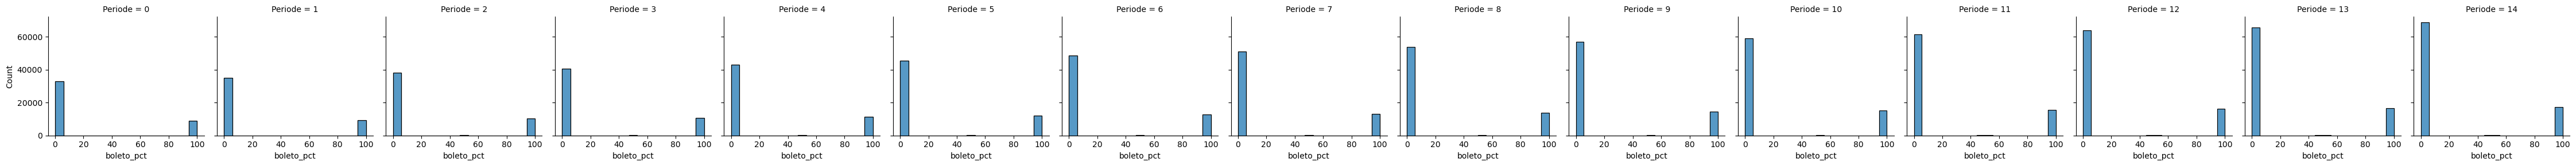

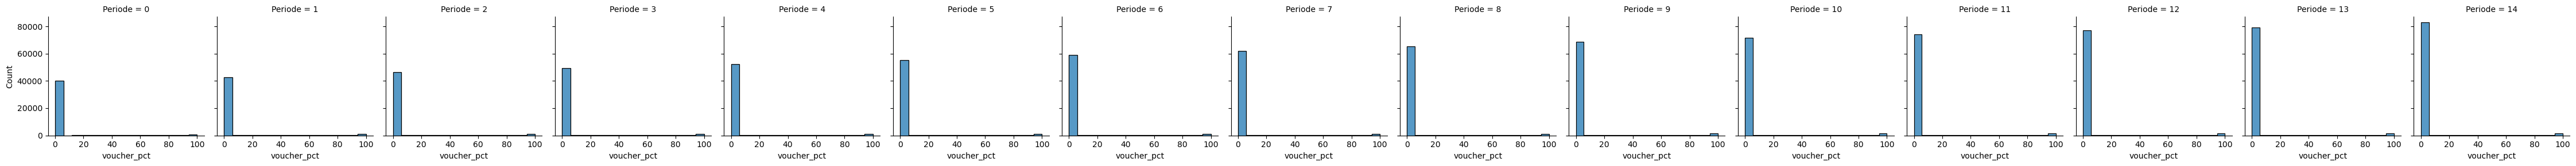

In [37]:
graphDistri(data_customer, data_payment, features)

### Graphique de série Temporelle

In [79]:
def graphStatsTimeSeries(customer_files, payment_files, features):
    stats_over_time = {'Periode': [], 'Moyenne': {},
                       'Mediane': {}, 'EcartType': {}}

    for i, (file_customer, file_payment) in enumerate(zip(customer_files,
                                                          payment_files)):
        # Charger les fichiers CSV
        df_customer = pd.read_csv(file_customer)
        df_payment = pd.read_csv(file_payment)

        # Prétraitement
        data = traitement_noscale(df_customer, df_payment, features)

        # Ajout de la colonne periode
        periode_label = f'Periode {i}'

        # calcul des stats
        stats_over_time['Periode'].append(periode_label)
        for feature in features:
            if feature not in stats_over_time['Moyenne']:
                stats_over_time['Moyenne'][feature] = []
                stats_over_time['Mediane'][feature] = []
                stats_over_time['EcartType'][feature] = []

            stats_over_time['Moyenne'][feature].append(data[feature].mean())
            stats_over_time['Mediane'][feature].append(data[feature].median())
            stats_over_time['EcartType'][feature].append(data[feature].std())

    # Affichage des graphiques
    fig, axs = plt.subplots(3, 4, figsize=(30, 20))
    axs = axs.ravel()
    for idx, feature in enumerate(features):
        # Placer les données sur le subplot correspondant
        ax = axs[idx % 12]  # 12 subplots au total
        ax.plot(stats_over_time['Periode'],
                stats_over_time['Moyenne'][feature],
                marker='o', label='Moyenne')
        ax.plot(stats_over_time['Periode'],
                stats_over_time['Mediane'][feature],
                marker='s', label='Mediane')
        ax.plot(stats_over_time['Periode'],
                stats_over_time['EcartType'][feature],
                marker='^', label='EcartType')

        # Réglage de l'échelle y pour chaque feature
        all_values = (stats_over_time['Moyenne'][feature]
                      + stats_over_time['Mediane'][feature]
                      + stats_over_time['EcartType'][feature])
        ymin, ymax = min(all_values), max(all_values)
        marge = (ymax - ymin) * 0.1
        ax.set_ylim(ymin - marge, ymax + marge)

        ax.set_title(f'Evolution de {feature}')
        ax.set_ylabel('Valeur')
        ax.set_xlabel('Période')
        ax.tick_params(axis='x', labelrotation=45)
        ax.legend()

    plt.tight_layout()
    plt.show()

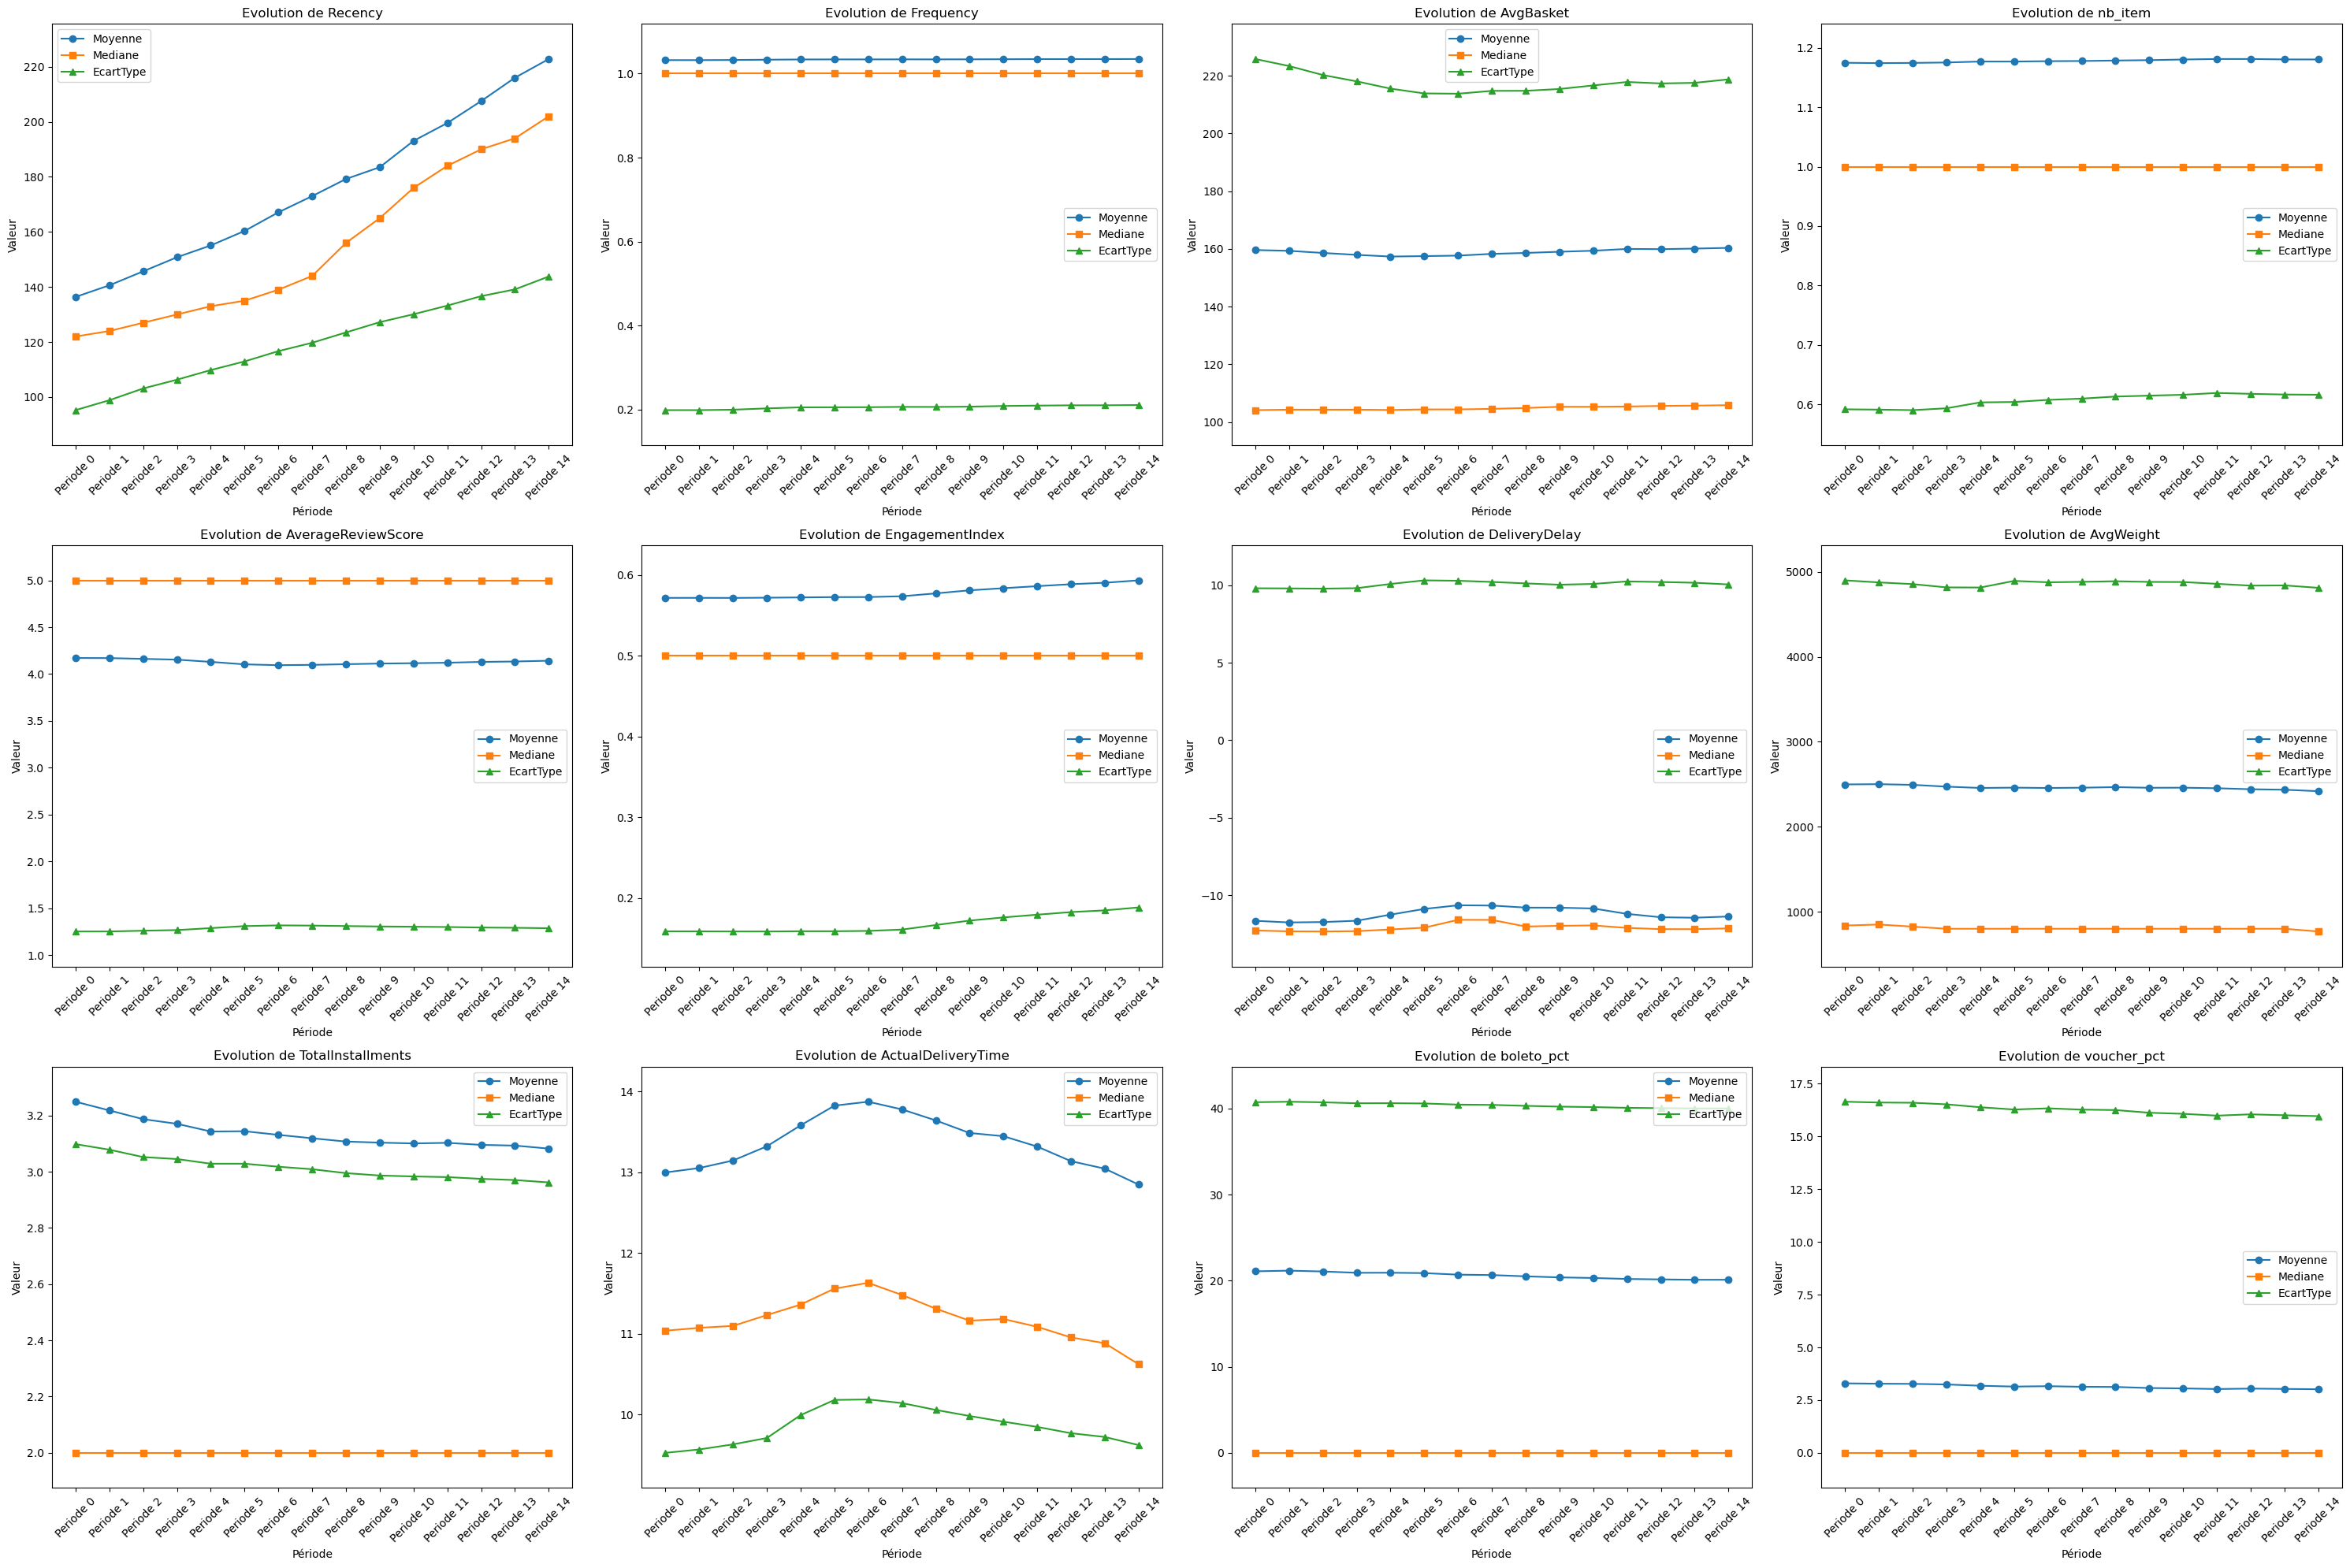

In [80]:
graphStatsTimeSeries(data_customer, data_payment, features)